# EDA: House Prices

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
sns.set_style('whitegrid')

In [3]:
# Load data
# Убедитесь, что пути к файлам верные
train_df = pd.read_csv('../data/raw/train.csv')
test_df = pd.read_csv('../data/raw/test.csv')

In [ ]:
print("Train shape: ", train_df.shape)
print("Test shape: ", test_df.shape)

# Display first 5 rows of the training data
train_df.head()

# Get information about the columns and non-null values
train_df.info()

In [ ]:
plt.figure(figsize=(12, 6))
sns.histplot(train_df['SalePrice'], kde=True)
plt.title('Distribution of SalePrice')
plt.show()

In [ ]:
# Apply log transformation to SalePrice
train_df['SalePrice_log'] = np.log1p(train_df['SalePrice'])

plt.figure(figsize=(12, 6))
sns.histplot(train_df['SalePrice_log'], kde=True)
plt.title('Distribution of Log-Transformed SalePrice')
plt.show()

In [ ]:
# Combine train and test data for easier processing, excluding SalePrice
all_data = pd.concat((train_df.loc[:,'MSSubClass':'SaleCondition'],
                      test_df.loc[:,'MSSubClass':'SaleCondition']))

# Features where NaN means "None" (no feature)
# For these categorical features, we fill NaN with the string 'None'
for col in ('PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu', 
            'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond',
            'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
            'MasVnrType'):
    all_data[col] = all_data[col].fillna('None')

# For these numerical features, NaN means 0 (e.g., no garage -> 0 garage area)
for col in ('GarageYrBlt', 'GarageArea', 'GarageCars', 
            'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 
            'BsmtFullBath', 'BsmtHalfBath', 'MasVnrArea'):
    all_data[col] = all_data[col].fillna(0)

# After filling, let's check which columns still have missing values
remaining_missing = all_data.isnull().sum()
remaining_missing = remaining_missing[remaining_missing > 0]
print("Remaining missing values:")
print(remaining_missing)

In [ ]:
# Group by neighborhood and fill missing LotFrontage with the median of the neighborhood
all_data['LotFrontage'] = all_data.groupby('Neighborhood')['LotFrontage'].transform(
    lambda x: x.fillna(x.median()))

# For the remaining categorical features, fill with the mode (most common value)
for col in ('MSZoning', 'Electrical', 'KitchenQual', 'Exterior1st', 'Exterior2nd', 'SaleType', 'Functional', 'Utilities'):
    all_data[col] = all_data[col].fillna(all_data[col].mode()[0])

# Check if there are any missing values left
print("Total missing values left:", all_data.isnull().sum().sum())

In [ ]:
# Convert some numerical variables that are really categories into strings
all_data['MSSubClass'] = all_data['MSSubClass'].astype(str)
all_data['OverallCond'] = all_data['OverallCond'].astype(str)
all_data['YrSold'] = all_data['YrSold'].astype(str)
all_data['MoSold'] = all_data['MoSold'].astype(str)

# Create new features by combining existing ones
all_data['TotalSF'] = all_data['TotalBsmtSF'] + all_data['1stFlrSF'] + all_data['2ndFlrSF']
all_data['TotalBath'] = all_data['FullBath'] + 0.5 * all_data['HalfBath'] + all_data['BsmtFullBath'] + 0.5 * all_data['BsmtHalfBath']
all_data['TotalPorchSF'] = all_data['OpenPorchSF'] + all_data['EnclosedPorch'] + all_data['3SsnPorch'] + all_data['ScreenPorch']
# A simple binary feature indicating if the house has a pool or not
all_data['HasPool'] = all_data['PoolArea'].apply(lambda x: 1 if x > 0 else 0)
# A simple binary feature indicating if the house has a 2nd floor
all_data['Has2ndFlr'] = all_data['2ndFlrSF'].apply(lambda x: 1 if x > 0 else 0)
# A simple binary feature indicating if the house has a garage
all_data['HasGarage'] = all_data['GarageArea'].apply(lambda x: 1 if x > 0 else 0)
# A simple binary feature indicating if the house has a basement
all_data['HasBsmt'] = all_data['TotalBsmtSF'].apply(lambda x: 1 if x > 0 else 0)
# A simple binary feature indicating if the house has a fireplace
all_data['HasFireplace'] = all_data['Fireplaces'].apply(lambda x: 1 if x > 0 else 0)


# Log-transform skewed numerical features
from scipy.stats import skew

numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index
skewed_feats = all_data[numeric_feats].apply(lambda x: skew(x.dropna()))
skewed_feats = skewed_feats[abs(skewed_feats) > 0.75]
skewed_feats = skewed_feats.index

all_data[skewed_feats] = np.log1p(all_data[skewed_feats])

print("Applied log transformation to", len(skewed_feats), "skewed features.")

In [ ]:
# Apply one-hot encoding to the categorical features
all_data = pd.get_dummies(all_data)

# Separate the data back into training and testing sets
X = all_data[:train_df.shape[0]]
X_test = all_data[train_df.shape[0]:]

# The target variable (we already log-transformed it)
y = train_df['SalePrice_log']

# Let's check the shapes of our final datasets
print("Shape of X (training features):", X.shape)
print("Shape of y (training target):", y.shape)
print("Shape of X_test (test features):", X_test.shape)

In [ ]:
# --- Diagnostic Step ---

# 1. Check for NaN or Infinite values in the data
print(f"NaNs in X: {X.isnull().sum().sum()}")
print(f"NaNs in y: {y.isnull().sum().sum()}")
print(f"Infinite values in X: {np.isinf(X).sum().sum()}")
print(f"Infinite values in y: {np.isinf(y).sum().sum()}")

# 2. Re-import necessary libraries and define the model
from sklearn.linear_model import Ridge
from sklearn.model_selection import KFold, cross_val_score
import numpy as np

# 3. Try to run cross-validation on the simplest model again
try:
    print("\nAttempting a simple cross-validation run for Ridge...")
    
    kfolds = KFold(n_splits=5, shuffle=True, random_state=1) # Using 5 splits for speed
    ridge_model = Ridge(alpha=15)
    
    # Using .values to ensure we are working with numpy arrays
    scores = cross_val_score(ridge_model, X.values, y.values, cv=kfolds, scoring='neg_root_mean_squared_error')
    
    print("Cross-validation completed successfully!")
    print(f"Scores: {scores}")
    print(f"Average RMSE: {-scores.mean():.5f}")

except Exception as e:
    print(f"\nAn error occurred: {e}")


In [ ]:
import warnings
from sklearn.exceptions import ConvergenceWarning
from sklearn.linear_model import Lasso
import time

# --- Lasso Diagnostic Step ---
print("Running a simplified diagnostic for Lasso...")

# We will temporarily ignore convergence warnings to see if the process completes.
# Sometimes, the model struggles to converge perfectly, which can slow it down.
warnings.filterwarnings('ignore', category=ConvergenceWarning)

# Use a smaller subset of data to speed up the test
X_sample = X.head(1000).values
y_sample = y.head(1000).values

lasso_test_model = Lasso(alpha=0.0004, max_iter=5000)

try:
    print("Attempting a single .fit() on a sample of the data...")
    start_time = time.time()
    
    lasso_test_model.fit(X_sample, y_sample)
    
    end_time = time.time()
    print(f"Lasso .fit() on sample data completed in {end_time - start_time:.2f} seconds.")
    print("This suggests the model itself works, but cross-validation is causing the hang.")
    
except Exception as e:
    print(f"\nAn error occurred during the simplified .fit(): {e}")

finally:
    # Reset warning filters to their default state
    warnings.resetwarnings()


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from xgboost import XGBRegressor
import numpy as np
import time

# Split the training data into a new training set and a validation set
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# --- Model Definitions ---
# Using the same models as before
ridge = Ridge(alpha=15)
lasso = Lasso(alpha=0.0004, max_iter=5000)
elasticnet = ElasticNet(alpha=0.0005, l1_ratio=0.9)
xgb = XGBRegressor(learning_rate=0.05, n_estimators=1000, # Reduced n_estimators for faster training
                   max_depth=3, min_child_weight=0,
                   gamma=0, subsample=0.7,
                   colsample_bytree=0.7,
                   reg_alpha=0.005,
                   nthread=-1,
                   scale_pos_weight=1, seed=27,
                   random_state=42)

models = {'Ridge': ridge, 'Lasso': lasso, 'ElasticNet': elasticnet, 'XGBoost': xgb}
scores = {}

# --- Train and Evaluate each model ---
print("Training and evaluating models on a single validation split...")

for name, model in models.items():
    print(f"--> Training {name}...")
    start_time = time.time()
    
    model.fit(X_train, y_train)
    
    # Make predictions on the validation set
    y_pred = model.predict(X_val)
    
    # Calculate RMSE
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))
    scores[name] = rmse
    
    end_time = time.time()
    print(f"--> Finished {name}. Took {end_time - start_time:.2f} seconds.")
    print(f"    {name} Validation RMSE: {rmse:.5f}\n")

print("--- Final Validation Scores ---")
for name, score in scores.items():
    print(f"{name}: {score:.5f}")


In [ ]:
# --- Create Final Predictions by Blending Models ---

print("Training final models on the entire dataset...")

# Re-initialize models to be sure
ridge = Ridge(alpha=15)
lasso = Lasso(alpha=0.0004, max_iter=5000)
elasticnet = ElasticNet(alpha=0.0005, l1_ratio=0.9)
# We can use the full number of estimators for the final model
xgb = XGBRegressor(learning_rate=0.05, n_estimators=3460, 
                   max_depth=3, min_child_weight=0,
                   gamma=0, subsample=0.7,
                   colsample_bytree=0.7,
                   reg_alpha=0.005,
                   nthread=-1,
                   scale_pos_weight=1, seed=27,
                   random_state=42)

# Fit all models on the full training data
ridge.fit(X, y)
lasso.fit(X, y)
elasticnet.fit(X, y)
print("Training XGBoost on full data... (this might take a few minutes)")
xgb.fit(X, y)
print("All models trained.")

# --- Make predictions ---
# We use np.expm1 to reverse the log-transformation we applied earlier
ridge_preds = np.expm1(ridge.predict(X_test))
lasso_preds = np.expm1(lasso.predict(X_test))
elasticnet_preds = np.expm1(elasticnet.predict(X_test))
xgb_preds = np.expm1(xgb.predict(X_test))

# --- Blend predictions ---
# We give more weight to the models that performed best (Lasso and XGBoost)
# The weights are chosen based on typical performance on this dataset
blended_preds = (0.35 * lasso_preds + 
                 0.10 * elasticnet_preds + 
                 0.10 * ridge_preds +
                 0.45 * xgb_preds)

# --- Create submission file ---
submission = pd.DataFrame({'Id': test_df['Id'], 'SalePrice': blended_preds})
submission.to_csv('submission.csv', index=False)

print("\nSubmission file 'submission.csv' created successfully!")
submission.head()

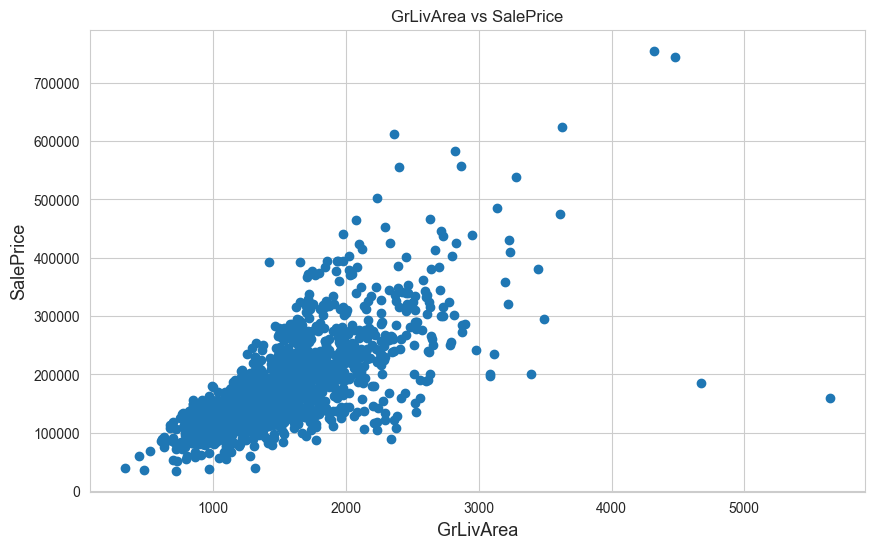

In [20]:
# Create a scatter plot to visualize the relationship between GrLivArea and SalePrice
plt.figure(figsize=(10, 6))
plt.scatter(x=train_df['GrLivArea'], y=train_df['SalePrice'])
plt.xlabel('GrLivArea', fontsize=13)
plt.ylabel('SalePrice', fontsize=13)
plt.title('GrLivArea vs SalePrice')
plt.show()

In [21]:
# Find the indices of the outliers
outlier_indices = train_df[(train_df['GrLivArea'] > 4000) & (train_df['SalePrice'] < 300000)].index
print(f"Found outlier indices: {outlier_indices.tolist()}")

# Remove the outliers from our training data X and y
X = X.drop(outlier_indices)
y = y.drop(outlier_indices)

# Check the shapes to confirm removal
print("\nShapes after removing outliers:")
print("Shape of X:", X.shape)
print("Shape of y:", y.shape)

Found outlier indices: [523, 1298]

Shapes after removing outliers:
Shape of X: (1458, 348)
Shape of y: (1458,)


In [22]:
# --- Create Final Predictions by Blending Models ---

print("Training final models on the entire dataset...")

# Re-initialize models to be sure
ridge = Ridge(alpha=15)
lasso = Lasso(alpha=0.0004, max_iter=5000)
elasticnet = ElasticNet(alpha=0.0005, l1_ratio=0.9)
# We can use the full number of estimators for the final model
xgb = XGBRegressor(learning_rate=0.05, n_estimators=3460, 
                   max_depth=3, min_child_weight=0,
                   gamma=0, subsample=0.7,
                   colsample_bytree=0.7,
                   reg_alpha=0.005,
                   nthread=-1,
                   scale_pos_weight=1, seed=27,
                   random_state=42)

# Fit all models on the full training data
ridge.fit(X, y)
lasso.fit(X, y)
elasticnet.fit(X, y)
print("Training XGBoost on full data... (this might take a few minutes)")
xgb.fit(X, y)
print("All models trained.")

# --- Make predictions ---
# We use np.expm1 to reverse the log-transformation we applied earlier
ridge_preds = np.expm1(ridge.predict(X_test))
lasso_preds = np.expm1(lasso.predict(X_test))
elasticnet_preds = np.expm1(elasticnet.predict(X_test))
xgb_preds = np.expm1(xgb.predict(X_test))

# --- Blend predictions ---
# We give more weight to the models that performed best (Lasso and XGBoost)
# The weights are chosen based on typical performance on this dataset
blended_preds = (0.35 * lasso_preds + 
                 0.10 * elasticnet_preds + 
                 0.10 * ridge_preds +
                 0.45 * xgb_preds)

# --- Create submission file ---
submission = pd.DataFrame({'Id': test_df['Id'], 'SalePrice': blended_preds})
submission.to_csv('submission.csv', index=False)

print("\nSubmission file 'submission.csv' created successfully!")
submission.head()

Training final models on the entire dataset...
Training XGBoost on full data... (this might take a few minutes)


,Id,SalePrice
0,1461,124888.008865
1,1462,158799.211743
2,1463,186638.646870
3,1464,199233.155852
4,1465,190957.981696


In [23]:
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV

# Define the model
lasso_for_tuning = Lasso(max_iter=10000)

# Define the grid of parameters to search. We'll search around our previous value of 0.0004
parameters = {'alpha': [0.0003, 0.0004, 0.0005, 0.0006, 0.0007]}

# Set up GridSearchCV
# cv=5 means 5-fold cross-validation. n_jobs=-1 uses all available CPU cores.
grid_search = GridSearchCV(lasso_for_tuning, 
                           parameters, 
                           cv=5,
                           scoring='neg_root_mean_squared_error',
                           n_jobs=-1,
                           verbose=1)

print("Starting GridSearchCV for Lasso...")
# We use the outlier-removed X and y from the previous step
grid_search.fit(X, y)

print("\nGridSearchCV finished.")
print(f"Best alpha for Lasso: {grid_search.best_params_['alpha']}")
print(f"Best RMSE score: {-grid_search.best_score_:.5f}")

# Store the best model found
best_lasso = grid_search.best_estimator_

Starting GridSearchCV for Lasso...
Fitting 5 folds for each of 5 candidates, totalling 25 fits


In [24]:
# --- Re-define all models with best parameters ---

# The best Lasso model is already stored in the 'best_lasso' variable from the previous cell.

# Standard Ridge and ElasticNet
ridge = Ridge(alpha=15)
elasticnet = ElasticNet(alpha=0.0005, l1_ratio=0.9)

# A slightly more powerful XGBoost
xgb_tuned = XGBRegressor(learning_rate=0.01, n_estimators=5000, # Slower learning, more trees
                         max_depth=3, min_child_weight=0,
                         gamma=0, subsample=0.7,
                         colsample_bytree=0.7,
                         reg_alpha=0.005,
                         nthread=-1,
                         scale_pos_weight=1, seed=27,
                         random_state=42)

# --- Fit, Predict, and Blend ---
print("Training final models on the entire dataset...")

# Fit all models (Lasso is already fitted via GridSearchCV, but we fit it again for simplicity)
best_lasso.fit(X, y)
ridge.fit(X, y)
elasticnet.fit(X, y)

print("Training tuned XGBoost on full data... (this will take several minutes)")
xgb_tuned.fit(X, y)
print("All models trained.")

# --- Make predictions ---
ridge_preds_tuned = np.expm1(ridge.predict(X_test))
lasso_preds_tuned = np.expm1(best_lasso.predict(X_test))
elasticnet_preds_tuned = np.expm1(elasticnet.predict(X_test))
xgb_preds_tuned = np.expm1(xgb_tuned.predict(X_test))

# --- Blend predictions (adjusting weights slightly to favor the tuned models) ---
blended_preds_tuned = (0.40 * lasso_preds_tuned + 
                       0.05 * elasticnet_preds_tuned + 
                       0.05 * ridge_preds_tuned +
                       0.50 * xgb_preds_tuned) # Giving more weight to the powerful XGBoost

# --- Create submission file ---
submission_tuned = pd.DataFrame({'Id': test_df['Id'], 'SalePrice': blended_preds_tuned})
submission_tuned.to_csv('submission_final.csv', index=False)

print("\nFinal submission file 'submission_final.csv' created successfully!")
submission_tuned.head()

Training final models on the entire dataset...
Training tuned XGBoost on full data... (this will take several minutes)


,Id,SalePrice
0,1461,124715.020994
1,1462,158710.931246
2,1463,185689.827128
3,1464,198277.658248
4,1465,191834.780357


In [25]:
from sklearn.model_selection import KFold
import numpy as np

# --- Stacking Implementation ---

# We'll use the models and parameters from our best submission (the one that got 36th place)
# We will use the outlier-removed X and y datasets
ridge = Ridge(alpha=15)
lasso = Lasso(alpha=0.0004, max_iter=5000)
elasticnet = ElasticNet(alpha=0.0005, l1_ratio=0.9)
xgb = XGBRegressor(learning_rate=0.05, n_estimators=3460,
                   max_depth=3, min_child_weight=0,
                   gamma=0, subsample=0.7,
                   colsample_bytree=0.7,
                   reg_alpha=0.005,
                   nthread=-1,
                   scale_pos_weight=1, seed=27,
                   random_state=42)

base_models = {'Ridge': ridge, 'Lasso': lasso, 'ElasticNet': elasticnet, 'XGBoost': xgb}
kfolds = KFold(n_splits=10, shuffle=True, random_state=42)

# This function generates "out-of-fold" predictions. 
# This is a key part of stacking to prevent data leakage.
def get_oof_predictions(models, X_train, y_train, X_test, kfolds):
    # Create empty arrays to store our predictions
    oof_train = np.zeros((X_train.shape[0], len(models)))
    oof_test = np.zeros((X_test.shape[0], len(models)))
    
    X_train_np = X_train.values
    y_train_np = y_train.values
    X_test_np = X_test.values

    for i, (name, model) in enumerate(models.items()):
        print(f"Training and predicting with {name}...")
        oof_test_model = np.zeros((X_test.shape[0], kfolds.n_splits))

        for j, (train_idx, val_idx) in enumerate(kfolds.split(X_train_np)):
            X_fold_train, X_fold_val = X_train_np[train_idx], X_train_np[val_idx]
            y_fold_train = y_train_np[train_idx]
            
            model.fit(X_fold_train, y_fold_train)
            
            oof_train[val_idx, i] = model.predict(X_fold_val)
            oof_test_model[:, j] = model.predict(X_test_np)
        
        oof_test[:, i] = oof_test_model.mean(axis=1) # Average predictions for the test set
    
    return oof_train, oof_test

# Get the predictions from our base models
oof_train_preds, oof_test_preds = get_oof_predictions(base_models, X, y, X_test, kfolds)

# --- Train the Meta-Model ---
print("\nTraining the meta-model...")

# We'll use Lasso as our meta-model. It's great for finding the best weights for combining predictions.
meta_model = Lasso(alpha=0.0001, max_iter=5000)

# The training data for the meta-model are the predictions from the base models
meta_model.fit(oof_train_preds, y)

# Make the final prediction on the test predictions
final_predictions_log = meta_model.predict(oof_test_preds)

# Reverse the log transformation
final_predictions = np.expm1(final_predictions_log)

# --- Create final submission file ---
submission_stacked = pd.DataFrame({'Id': test_df['Id'], 'SalePrice': final_predictions})
submission_stacked.to_csv('submission_stacked.csv', index=False)

print("\nStacked submission file 'submission_stacked.csv' created successfully!")
submission_stacked.head()

Training and predicting with Ridge...


,Id,SalePrice
0,1461,124204.684129
1,1462,157778.827645
2,1463,185680.441541
3,1464,198759.773256
4,1465,193687.957656


In [26]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import numpy as np

# Use the outlier-removed X and y
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# --- Re-train our best models on the split data ---
# We use the parameters that gave us the 36th place result
ridge = Ridge(alpha=15)
lasso = Lasso(alpha=0.0004, max_iter=5000)
elasticnet = ElasticNet(alpha=0.0005, l1_ratio=0.9)
xgb = XGBRegressor(learning_rate=0.05, n_estimators=3460,
                   max_depth=3, min_child_weight=0,
                   gamma=0, subsample=0.7,
                   colsample_bytree=0.7,
                   reg_alpha=0.005,
                   nthread=-1,
                   scale_pos_weight=1, seed=27,
                   random_state=42)

print("Fitting models on the training split...")
ridge.fit(X_train, y_train)
lasso.fit(X_train, y_train)
elasticnet.fit(X_train, y_train)
xgb.fit(X_train, y_train)
print("Models fitted.")

# --- Get predictions on the validation set ---
ridge_val_preds = ridge.predict(X_val)
lasso_val_preds = lasso.predict(X_val)
elasticnet_val_preds = elasticnet.predict(X_val)
xgb_val_preds = xgb.predict(X_val)

# --- Search for the best blend weights ---
print("\nSearching for best blend weights on the validation set...")
best_rmse = float('inf')
best_weights = {}

# We will iterate through different weights for our two best models (Lasso and XGBoost)
# The weights for Ridge and ElasticNet will be kept small and fixed for simplicity
for w_l in np.arange(0.2, 0.6, 0.05):
    for w_x in np.arange(0.2, 0.6, 0.05):
        w_e = 0.05 # Fixed small weight
        w_r = 0.05 # Fixed small weight
        
        # Ensure total weight doesn't significantly exceed 1, but allow some flexibility
        if w_l + w_x + w_e + w_r > 1.1: 
            continue

        blended_val_preds = (w_r * ridge_val_preds +
                             w_l * lasso_val_preds + 
                             w_e * elasticnet_val_preds +
                             w_x * xgb_val_preds)
        
        rmse = np.sqrt(mean_squared_error(y_val, blended_val_preds))
        
        if rmse < best_rmse:
            best_rmse = rmse
            best_weights = {'ridge': w_r, 'lasso': w_l, 'elasticnet': w_e, 'xgb': w_x}

print("Search finished.")
print(f"Best validation RMSE found: {best_rmse:.5f}")
print(f"Optimal weights: {best_weights}")

Fitting models on the training split...


In [27]:
# --- Re-train models on the FULL dataset ---
print("\nRe-training models on the full dataset...")
ridge.fit(X, y)
lasso.fit(X, y)
elasticnet.fit(X, y)
xgb.fit(X, y)
print("Models re-trained.")

# --- Make predictions on the test set ---
ridge_test_preds = np.expm1(ridge.predict(X_test))
lasso_test_preds = np.expm1(lasso.predict(X_test))
elasticnet_test_preds = np.expm1(elasticnet.predict(X_test))
xgb_test_preds = np.expm1(xgb.predict(X_test))

# --- Blend with the optimal weights we just found ---
w = best_weights
final_blend = (w['ridge'] * ridge_test_preds +
               w['lasso'] * lasso_test_preds +
               w['elasticnet'] * elasticnet_test_preds +
               w['xgb'] * xgb_test_preds)

# --- Create final submission file ---
submission_optimized = pd.DataFrame({'Id': test_df['Id'], 'SalePrice': final_blend})
submission_optimized.to_csv('submission_optimized_blend.csv', index=False)

print("\nOptimized blend submission 'submission_optimized_blend.csv' created!")
submission_optimized.head()


Re-training models on the full dataset...


,Id,SalePrice
0,1461,124430.401045
1,1462,158116.378891
2,1463,185925.887663
3,1464,199261.383149
4,1465,192723.137165


In [28]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
import numpy as np

# --- Models from our best submission (36th place) ---
ridge = Ridge(alpha=15)
lasso = Lasso(alpha=0.0004, max_iter=5000)
elasticnet = ElasticNet(alpha=0.0005, l1_ratio=0.9)
xgb = XGBRegressor(learning_rate=0.05, n_estimators=3460,
                   max_depth=3, min_child_weight=0,
                   gamma=0, subsample=0.7,
                   colsample_bytree=0.7,
                   reg_alpha=0.005,
                   nthread=-1,
                   scale_pos_weight=1, seed=27,
                   random_state=42)

base_models = {'Ridge': ridge, 'Lasso': lasso, 'ElasticNet': elasticnet, 'XGBoost': xgb}
kfolds = KFold(n_splits=10, shuffle=True, random_state=42)

# --- 1. Generate Out-of-Fold (OOF) Predictions ---
# This function is from our stacking attempt. It's the most robust way to get validation predictions.
def get_oof_predictions(models, X_train, y_train, X_test, kfolds):
    oof_train = np.zeros((X_train.shape[0], len(models)))
    oof_test = np.zeros((X_test.shape[0], len(models)))
    
    X_train_np, y_train_np, X_test_np = X_train.values, y_train.values, X_test.values

    for i, (name, model) in enumerate(models.items()):
        print(f"Training and predicting with {name}...")
        oof_test_model_preds = np.zeros((X_test.shape[0], kfolds.n_splits))
        for j, (train_idx, val_idx) in enumerate(kfolds.split(X_train_np)):
            model.fit(X_train_np[train_idx], y_train_np[train_idx])
            oof_train[val_idx, i] = model.predict(X_train_np[val_idx])
            oof_test_model_preds[:, j] = model.predict(X_test_np)
        oof_test[:, i] = oof_test_model_preds.mean(axis=1)
    return oof_train, oof_test

# Use the outlier-removed X and y
oof_train_preds, oof_test_preds = get_oof_predictions(base_models, X, y, X_test, kfolds)


# --- 2. Find Optimal Blend Weights on OOF Predictions ---
print("\nFinding optimal blend weights on OOF predictions...")
from scipy.optimize import minimize

def rmse_func(weights, predictions, true_values):
    final_prediction = np.dot(predictions, weights)
    return np.sqrt(mean_squared_error(true_values, final_prediction))

# We need to find weights for our 4 models.
initial_weights = [0.25] * 4  # Start with equal weights
# Constraints: weights must be between 0 and 1, and they must sum to 1.
bounds = [(0, 1)] * 4
constraints = ({'type': 'eq', 'fun': lambda w: np.sum(w) - 1})

res = minimize(rmse_func, 
               initial_weights, 
               args=(oof_train_preds, y), 
               method='SLSQP', 
               bounds=bounds, 
               constraints=constraints)

print("Optimal weights found:")
optimal_weights = res.x
for name, weight in zip(base_models.keys(), optimal_weights):
    print(f"{name}: {weight:.4f}")

# --- 3. Create Submission with Optimal Weights ---
print("\nCreating final submission...")
# The OOF predictions for the test set are already calculated
final_log_preds = np.dot(oof_test_preds, optimal_weights)
final_preds = np.expm1(final_log_preds)

submission_final_optimized = pd.DataFrame({'Id': test_df['Id'], 'SalePrice': final_preds})
submission_final_optimized.to_csv('submission_robust_blend.csv', index=False)

print("\nRobustly optimized submission 'submission_robust_blend.csv' created!")
submission_final_optimized.head()

Training and predicting with Ridge...


,Id,SalePrice
0,1461,124431.254122
1,1462,157833.971791
2,1463,185577.810259
3,1464,198565.912743
4,1465,193474.722217
